In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['axes.edgecolor']='black'
matplotlib.rcParams['xtick.color']='black'
matplotlib.rcParams['ytick.color']='black'
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=["black", "#e94cdc", "0.7"])
matplotlib.rcParams['axes.linewidth']=1.3
matplotlib.rcParams['text.color']='black'
from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [2]:
matplotlib.rcParams['figure.figsize'] = (10, 6)

### Задача 3

Вы располагаете данными о динамике популяций лис и кроликов в некотором регионе (файл fox_rabbit). Предполагается, что численности этих популяций взаимосвязаны между собой и описываются моделью векторной авторегрессии VAR(p).

(а) Определите оптимальный порядок лага для VAR модели, опираясь на информационный критерий Шварца.

(б) Оцените параметры модели. Запишите полученные уравнения регрессии в стандартной форме, указав коэффициенты детерминации и (в скобках под соответствующими коэффициентами) стандартные ошибки. Укажите, какие из переменных являются значимыми при уровне значимости 1%.

(в) Постройте прогноз популяции кроликов на один период вперед, укажите 95-процентный доверительный интервал прогноза.

(г) Допустим, в вашем распоряжении нет исходных данных, а есть только уравнения,
оцененные в пункте (б). Вычислите равновесный уровень (безусловное математическое ожидание) численности лис в регионе. Приведите необходимые расчеты.

(д) Постройте график отклика функции на импульс, характеризующий динамику численности лис в ответ на импульс численности кроликов. Поясните, какие идентификационные ограничения вы используете. Дайте содержательную интерпретацию такого вида графика.

(е) Для двух переменных, имеющихся в вашем распоряжении, осуществите тест Грейнжера на причинно-следственную связь и интерпретируйте его результаты.

In [6]:
dat = pd.read_excel('/Users/anton.andreytsev/Downloads/fox_rabbit.xls')

In [7]:
dat.head()

,fox,rabbit
0,13.997,5.987
1,13.994,6.008
2,14.013,6.024
3,13.997,6.003
4,14.011,5.992


Подбор параметров на основе AIC и BIC

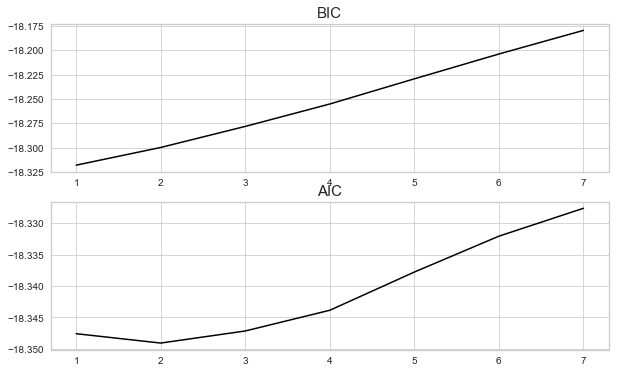

<Figure size 720x720 with 0 Axes>

In [116]:
bic = []
aic = []
lags = list(range(1, 7+1))
for lag in lags:
    model_fox_rabbit = VAR(dat).fit(lag)
    bic.append(model_fox_rabbit.bic)
    aic.append(model_fox_rabbit.aic)
    
fig, ax = plt.subplots(nrows=2, ncols=1);
plt.figure(figsize=(10, 10));
ax[0].set_title('BIC', fontsize=15)
ax[0].plot(lags, bic);
ax[1].set_title('AIC', fontsize=15)
ax[1].plot(lags, aic);

Автоподбор параметров

In [70]:
# Автоподбор параметров
model_fox_rabbit = VAR(dat)
a = model_fox_rabbit.select_order(5)
a.selected_orders

{'aic': 2, 'bic': 1, 'hqic': 1, 'fpe': 2}

Оценка модели

In [127]:
model_fox_rabbit = VAR(dat).fit(2)
print(model_fox_rabbit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, May, 2019
Time:                     13:49:42
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -18.2999
Nobs:                     998.000    HQIC:                  -18.3304
Log likelihood:           6333.98    FPE:                1.07424e-08
AIC:                     -18.3491    Det(Omega_mle):     1.06355e-08
--------------------------------------------------------------------
Results for equation fox
               coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------
const             3.708628         0.486001            7.631           0.000
L1.fox            0.505674         0.031729           15.937           0.000
L1.rabbit         0.480167         0.031207           15.386           0.000
L

Оценённая модель в скалярной форме

$\hat{fox}_{t} = \underset{(0.49)}{3.71} + \underset{(0.03)}{0.51} \cdot fox_{t-1} + \underset{(0.03)}{0.48} \cdot rabbit_{t-1} + \underset{(0.03)}{0.02} \cdot fox_{t-2} + \underset{(0.03)}{0.006} \cdot rabbit_{t-2}$

$\hat{rabbit}_{t} = \underset{(0.49)}{9.15} - \underset{(0.03)}{0.54} \cdot fox_{t-1} + \underset{(0.03)}{0.56} \cdot rabbit_{t-1} + \underset{(0.03)}{0.08} \cdot fox_{t-2} - \underset{(0.03)}{0.04} \cdot rabbit_{t-2}$

Прогноз популяции на один период

In [105]:
forecast_1 = model_fox_rabbit.forecast(y=dat.values, steps=1)
print(forecast_1)
print('В следующем периоде кроликов будет {} штук'.format(np.round(forecast_1[0][1], decimals=3)))

[[14.00518591  6.00567637]]
В следующем периоде кроликов будет 6.006 штук


Вычисление безусловного мат ожидания

$\vec y_{t} = \vec \alpha + B \cdot \vec y_{t-1} + C \cdot \vec y_{t-2} + \vec \epsilon_{t}$

$\mathbb{E} \left( \vec y_{t} \right) = \vec \alpha + B \cdot \mathbb{E} \left( \vec y_{t-1} \right) + C \cdot \mathbb{E} \left( \vec y_{t-2} \right) \Rightarrow \vec \mu = \vec \alpha + B \cdot \vec \mu + C \cdot \vec \mu \Rightarrow \left(I - B - C  \right) \cdot \vec \mu = \vec \alpha \Rightarrow \boxed{\vec \mu = \left(I - B - C  \right)^{-1} \cdot \vec \alpha}$

In [115]:
alpha = model_fox_rabbit.intercept
B, C = model_fox_rabbit.coefs
mu = np.linalg.inv(np.eye(2) - B - C).dot(alpha)
print(mu)
print("Безусловное матожидание численности лис в регионе равно {}".format(np.round(mu[0], decimals=3)))

[13.99979699  5.99960911]
Безусловное матожидание численности лис в регионе равно 14.0


Графики отклика

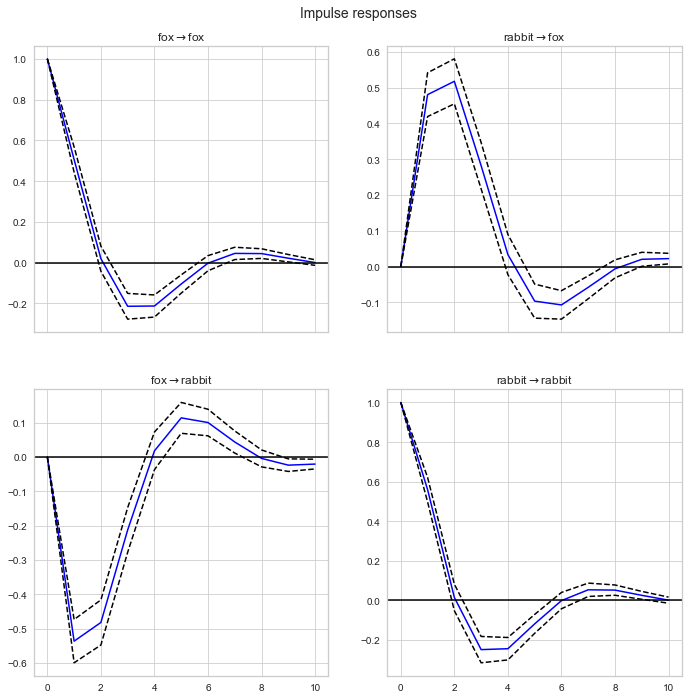

In [85]:
model_fox_rabbit.irf(periods=10).plot();

Тест Гренджера

In [126]:
fox_causing_rabbit = model_fox_rabbit.test_causality(caused='rabbit', causing='fox', kind='f')
print(fox_causing_rabbit.h0)
print(fox_causing_rabbit.conclusion)

rabbit_causing_fox = model_fox_rabbit.test_causality(caused='fox', causing='rabbit', kind='f')
print(rabbit_causing_fox.h0)
print(rabbit_causing_fox.conclusion)

H_0: fox does not Granger-cause rabbit
reject
H_0: rabbit does not Granger-cause fox
reject


Нельзя сделать однозначный вывод о направленности влияния

### Задача 4

Файл с данными: USMacro_Quarterly. Данные квартальные.

$realGDP_{t}$ — реальный ВВП США

$TBillrate_{t}$ — доходность по государственным казначейским векселям.


(а) Ограничьте выборку периодом 1955:1 – 2009:4. Создайте переменную $\Delta y_{t}$, где
$ y_{t} = \log realGDP_{t}$. Созданная таким образом переменная характеризует темп прироста реального ВВП. Создайте аналогичную переменную $\Delta R_{t}$, где $R_{t} = \log TBillrate_{t}$.

(б) Тестируйте стационарность переменных $\Delta y_{t}$ и $\Delta R_{t}$.

(в) Оцените модель VAR(4) для переменных $\Delta y_{t}$ и $\Delta R_{t}$. Является ли ∆𝑌𝑡 причиной по Грейнжеру для переменной $\Delta R_{t}$? А наоборот? Подтверждает ли представленная модель работоспособность механизма кредитно-денежной трансмиссии?

In [134]:
dat = pd.read_excel('/Users/anton.andreytsev/Downloads/UsMacro_Quarterly.xlsx')
index1 = dat.loc[(dat.Year == 1955)&(dat.Quarter == 1)].index[0]
index2 = dat.loc[(dat.Year == 2009)&(dat.Quarter == 4)].index[0]
dat = dat.loc[index1:index2]

In [135]:
dat.head()

,Year,Quarter,RealGDP,TBillRate
32,1955,1,2449.748,1.223333
33,1955,2,2490.274,1.483333
34,1955,3,2523.548,1.856667
35,1955,4,2537.637,2.336667
36,1956,1,2526.058,2.326667


In [138]:
delta_y = np.diff(np.log(dat.RealGDP))
delta_r = np.diff(np.log(dat.TBillRate))

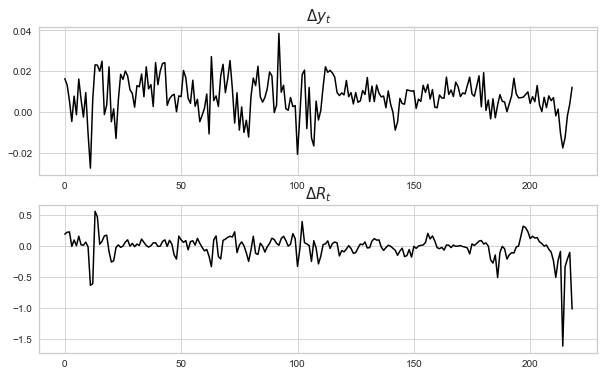

<Figure size 720x720 with 0 Axes>

In [142]:
fig, ax = plt.subplots(nrows=2, ncols=1);
plt.figure(figsize=(10, 10));
ax[0].set_title('$\Delta y_{t}$', fontsize=15)
ax[0].plot(delta_y);
ax[1].set_title('$\Delta R_{t}$', fontsize=15)
ax[1].plot(delta_r);

"На глаз" оба ряда стационарные, используем формальные стат тесты

In [143]:
from statsmodels.tsa.stattools import adfuller, kpss

In [148]:
print('Дики-Фуллер p-value для delta_y: {}'.format(adfuller(delta_y)[1]))
print('Дики-Фуллер p-value для delta_r: {}'.format(adfuller(delta_r)[1]))
print('KPSS p-value для delta_y: {}'.format(kpss(delta_y)[1]))
print('KPSS p-value для delta_r: {}'.format(kpss(delta_r)[1]))

Дики-Фуллер p-value для delta_y: 2.206041681613593e-11
Дики-Фуллер p-value для delta_r: 0.006556085420125244
KPSS p-value для delta_y: 0.1
KPSS p-value для delta_r: 0.05872111360780326


Оба теста на 1% уровне значимости принимают гипотезу о стационарности обоих рядов

Оценивание Var(4)

In [156]:
dat_delta = pd.DataFrame([delta_r, delta_y]).T
dat_delta.columns = ['delta_r', 'delta_y']

In [158]:
model_macro = VAR(dat_delta).fit(4)
print(model_macro.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, May, 2019
Time:                     14:19:34
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -12.8595
Nobs:                     215.000    HQIC:                  -13.0277
Log likelihood:           820.592    FPE:                1.96185e-06
AIC:                     -13.1417    Det(Omega_mle):     1.80736e-06
--------------------------------------------------------------------
Results for equation delta_r
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const             -0.056805         0.021612           -2.628           0.009
L1.delta_r         0.192928         0.075367            2.560           0.010
L1.delta_y         6.522154         1.411320            4.621         

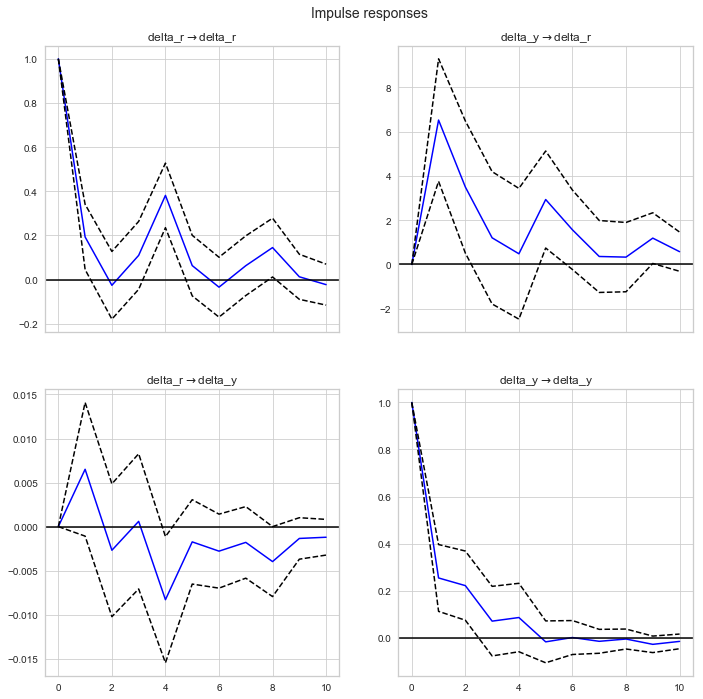

In [160]:
model_macro.irf().plot();

In [162]:
y_causing_r = model_macro.test_causality(caused='delta_r', causing='delta_y', kind='f')
print(y_causing_r.h0)
print(y_causing_r.conclusion)

r_causing_y = model_macro.test_causality(caused='delta_y', causing='delta_r', kind='f')
print(r_causing_y.h0)
print(r_causing_y.conclusion)

H_0: delta_y does not Granger-cause delta_r
reject
H_0: delta_r does not Granger-cause delta_y
fail to reject


Исходя из теста Грейнджера принимаем гипотезу о том, что delta_y явяется "причиной по Грейнджеру" для delta_r

### Задача 5

Имеется SVAR-модель в структурной форме:

$\begin{aligned} y_{1 t} &=8-0,5 y_{2 t}+0,4 y_{1 t-1}+0,2 y_{2 t-1}+\varepsilon_{1 t} \\ y_{2 t} &=16-0,4 y_{1 t}+0,4 y_{1 t-1}+0,2 y_{2 t-1}+\varepsilon_{2 t} \end{aligned}$

$E\left(\varepsilon_{1 t}\right)=E\left(\varepsilon_{2 t}\right)=\operatorname{cov}\left(\varepsilon_{1 t}, \varepsilon_{2 t}\right)=0, \operatorname{var}\left(\varepsilon_{1 t}\right)=2, \operatorname{var}\left(\varepsilon_{2 t}\right)=4$

(а) Выпишите модель в приведенной форме.

(б) Найдите ковариационную матрицу случайных ошибок приведенной формы:
    
$\left( \begin{array}{cc}{E u_{1 t}^{2}} & {E u_{1 t} u_{2 t}} \\ {E u_{1 t} u_{2 t}} & {E u_{2 t}^{2}}\end{array}\right)$

(в) Вычислите три первых элемента функции импульсного отклика 1-ой переменной
на единичный шок 2-ой переменной.

Введём обозначение $f_{t} = \begin{pmatrix} f_{1} \\ f_{2} \end{pmatrix}_{t}$, тогда SVAR принимает вид:

$\underbrace{\begin{pmatrix} 1 & 0.5 \\ 0.4 & 1   \end{pmatrix}}_{A} \cdot y_{t} = \underbrace{\begin{pmatrix}  8 \\ 16  \end{pmatrix}}_{\alpha} + \underbrace{\begin{pmatrix} 0.4 & 0.2 \\ 0.4 & 0.2   \end{pmatrix}}_{B} \cdot y_{t-1} + \epsilon_{t} \Rightarrow A \cdot y_{t} = \alpha + B \cdot y_{t-1} + \epsilon_{t}$

Отсюда получаем, что приведённая форма имеет вид:

$y_{t} = A^{-1} \cdot \alpha + A^{-1} \cdot B \cdot y_{t-1} + A^{-1} \cdot \epsilon_{t} = a + C \cdot y_{t-1} + u_{t}$

In [6]:
A = np.array([[1 ,0.5], 
              [0.4, 1]])

B = np.array([[0.4, 0.2], 
              [0.4, 0.2]])

alpha = np.array([8, 16])

In [12]:
a = np.linalg.inv(A).dot(alpha)
C = np.linalg.inv(A).dot(B)
u = np.linalg.inv(A)
print(a)
print()
print(C)
print()
print(u)

[ 0. 16.]

[[0.25  0.125]
 [0.3   0.15 ]]

[[ 1.25  -0.625]
 [-0.5    1.25 ]]


Приведённая форма

$y_{t} = \begin{pmatrix} 0 \\ 16 \end{pmatrix} + \begin{pmatrix} 0.25 & 0.125 \\ 0.3 & 0.15  \end{pmatrix} \cdot y_{t-1} + \begin{pmatrix} 1.25 & -0.625 \\ -0.5 & 1.25 \end{pmatrix} \cdot \epsilon_{t}$

In [13]:
u.dot(np.diag([2, 4])).dot(u.T)

array([[ 4.6875, -4.375 ],
       [-4.375 ,  6.75  ]])

Ковариационная матрица случайных ошибок приведённой формы будет иметь вид:

$\mathbb{D}(u_{t}) = \mathbb{D}(A^{-1} \epsilon_{t}) = A^{-1} \cdot \mathbb{D}(\epsilon_{t}) \cdot A^{-T} = \begin{pmatrix} 1.25 & -0.625 \\ -0.5 & 1.25 \end{pmatrix} \cdot \begin{pmatrix} 2 & 0 \\ 0 & 4 \end{pmatrix} \cdot \begin{pmatrix} 1.25 & -0.5 \\ -0.625 & 1.25 \end{pmatrix} = \begin{pmatrix} 4.688 & -4.375 \\ -4.375 & 6.75 \end{pmatrix}$

Для нахождения функции отклика представим приведённую форму в виде бесконечного МА процесса

$y_{t} = a + C \cdot y_{t-1} + u_{t} = a + C \cdot L \cdot  y_{t} + u_{t} \Rightarrow (I - CL)y_{t} = a + u_{t} \Rightarrow y_{t} = (I - CL)^{-1}a + (I - CL)^{-1}u_{t} \ $,  где L - лаговый оператор ($L(f_{t}) = f_{t-1}$)

Используя факт, что $(I - CL)^{-1} = \sum\limits_{i=0}^{\infty} C^{i}L^{i}$, получаем

$y_{t} = \underbrace{(I - C)^{-1}a}_{\mu} + \sum\limits_{i=0}^{\infty} C^{i}\underbrace{L^{i}u_{t}}_{u_{t-i}} = \mu + \sum\limits_{i=0}^{\infty} C^{i}A^{-1}\epsilon_{t-i}$

Тогда (p, q) элемент матрицы $C^{i}A^{-1}$ и будет откликом p-ой переменной на единичный шок q-ой экзогенной переменной через i периодов

In [21]:
np.linalg.matrix_power(C, 0).dot(np.linalg.inv(A))

array([[ 1.25 , -0.625],
       [-0.5  ,  1.25 ]])

отклик 1ой переменной на шок второй переменной в первом периоде равен -0.625

In [22]:
np.linalg.matrix_power(C, 1).dot(np.linalg.inv(A))

array([[0.25, 0.  ],
       [0.3 , 0.  ]])

отклик 1ой переменной на шок второй переменной во втором периоде равен 0

In [23]:
np.linalg.matrix_power(C, 2).dot(np.linalg.inv(A))

array([[0.1 , 0.  ],
       [0.12, 0.  ]])

отклик 1ой переменной на шок второй переменной в третьем периоде равен 0